In [1]:
from __future__ import annotations

import collections
import csv
import json
import logging
import math
import os
import pickle
import re
from itertools import chain, combinations, islice, product
from typing import Any, TypeAlias

import numpy as np
import numpy.typing as npt
import ray
from matplotlib import pyplot as plt
from sklearn.neighbors import KDTree
from tqdm import tqdm

log = logging.getLogger("aa72")
with open("logging.config.json", "rt") as f:
    logging.config.dictConfig(json.load(f))

Point: TypeAlias = npt.NDArray[np.floating]
PointArray: TypeAlias = npt.NDArray[np.floating]

Side: TypeAlias = dict[str, str | PointArray]

# Load Data

In [2]:
IN_PATH = os.path.join("data", "out_02", "out.pickle")

sides: dict[int, list[Side]] = {}
with open(IN_PATH, "rb") as f:
    for piece_id, piece_sides in tqdm(pickle.load(f)):
        if piece_id in range(40 + 1):
            for piece_side in piece_sides:
                piece_side["points"] = np.array(piece_side["points"])

            sides[piece_id] = piece_sides

100%|██████████| 2000/2000 [00:00<00:00, 44290.90it/s]


# Side comparison score

Calculate the comparison score between two sets of points using the Iterative Closest Point (ICP) algorithm.
The comparison score represents the average distance between corresponding points in the source and destination sets. Lower score means better match.

The order of the source and destination arrays may affect the result.

*Based on [this tutorial](https://nghiaho.com/?page_id=671) and [this icp implementation](https://github.com/ClayFlannigan/icp).*


In [3]:
def icp(src: PointArray, dst: PointArray) -> float:
    src_rows, src_dims = src.shape
    dst_rows, dst_dims = dst.shape

    # Should work for points with any dimensions
    n = max(src_dims, dst_dims)

    # Make points homogenious (this also ensures the same dimensionality for src and dst)
    src_h = np.zeros((src_rows, n + 1), dtype=np.float32)
    dst_h = np.zeros((dst_rows, n + 1), dtype=np.float32)
    src_h[:, n] = 1
    dst_h[:, n] = 1
    src_h[:, :src_dims] = src
    dst_h[:, :dst_dims] = dst

    prev_error = np.inf  # error history for early stop
    score = np.inf  # score (average error)

    tree = KDTree(dst_h, leaf_size=5, p=1)

    iterations = 100
    for _ in range(iterations):
        # Guess which points in dst correspond to points in src based on shortest distance
        distances, idxs = tree.query(src_h, k=1)

        # Calculate error as average distance between points in dst and src
        error = np.mean(distances)

        # Update the score
        score = error if error < score else score

        # Early stop if there is no improvement or error gets worse
        if np.abs(prev_error - error) < 10e-3:
            break
        prev_error = error

        # Select subset of points from dst for transformations
        dst_s = dst_h[idxs.flatten()]

        # Translate to centroids
        src_centroid = np.mean(src_h, axis=0)
        dst_centroid = np.mean(dst_s, axis=0)
        src_c = src_h - src_centroid
        dst_c = dst_s - dst_centroid

        # Calculate rotation matrix
        h = src_c.T @ dst_c
        u, _, v = np.linalg.svd(h)
        r = v.T @ u.T

        # Special reflection case
        if np.linalg.det(r) < 0:
            v[-1, :] *= -1
            r = v.T @ u.T

        # Translation vector
        t = dst_centroid - r @ src_centroid.T

        # Apply transformations to src
        src_h = (r @ src_h.T).T + t
    else:
        # Final score update in case of no early stop
        distances, idxs = tree.query(src_h, k=1)
        error = np.mean(distances)
        score = error if error < score else score

    return score, src_h, dst_h

In [4]:
# Sanity check

a = np.array([[0, 1], [1, 1], [2, 1], [3, 2]], dtype=float)
b = np.array([[1, 1], [2, 2], [2, 3], [2, 4]], dtype=float)
print("score:", icp(a, b)[0], icp(b, a)[0])

a = np.array([[0, 1], [1, 1], [2, 1], [3, 2]], dtype=float)
b = np.array([[2, -1], [2, 0], [2, 1], [1, 2]], dtype=float)
print("score:", icp(a, b)[0], icp(b, a)[0])

a = np.array([[0, 1], [1, 1], [2, 1], [3, 1]], dtype=float)
b = np.array([[1, 1], [2, 1], [3, 1], [4, 1]], dtype=float)
print("score:", icp(a, b)[0], icp(b, a)[0])

a = np.array([[0, 1], [1, 1], [2, 1], [3, 1]], dtype=float)
b = np.array([[0, 2], [1, 2], [2, 2], [3, 2]], dtype=float)
print("score:", icp(a, b)[0], icp(b, a)[0])

score: 0.75 0.3278737850487232
score: 1.25 0.608783908188343
score: 0.25 0.25
score: 0.0 0.0


In [5]:
def get_score(
    src_id: int,
    src: PointArray,
    dst_id: int,
    dst: PointArray,
    reverse=True,
) -> float:
    # Try matching larger side to smaller (to include side length in the comparison)
    if len(dst) > len(src):
        dst, src = src, dst

    # Ensure the output is deterministic(ish) in edge cases
    elif len(dst) == len(src) and src_id > dst_id:
        dst, src = src, dst

    # If checking hole/knob match, one has to be reversed before ICP score
    if reverse:
        src = -src
        src[:, 0] -= src[:, 0].min()
        src[:, 1] -= src[:, 1].min()

    # Subsample source, to speed up calculations
    keep_percentage = 0.5
    subsampling_step = int(1 / keep_percentage)
    src = src[::subsampling_step]

    return icp(src, dst)

In [6]:
piece_a_id = 1
piece_b_id = 2
sides_a = sides[piece_a_id]
sides_b = sides[piece_b_id]

reverse = sides_a is not sides_b

for a_idx, side_a in enumerate(sides_a):
    for b_idx, side_b in enumerate(sides_b):
        score, src, dst = get_score(
            piece_a_id,
            side_a["points"],
            piece_b_id,
            side_b["points"],
            reverse,
        )
        print(f"{a_idx = } ({side_a['type']}), {b_idx = } ({side_b['type']}); score: {score:7.3f}")  # fmt: skip

a_idx = 0 (flat), b_idx = 0 (knob); score: 142.086
a_idx = 0 (flat), b_idx = 1 (knob); score:  97.922
a_idx = 0 (flat), b_idx = 2 (flat); score:  25.107
a_idx = 0 (flat), b_idx = 3 (hole); score: 102.190
a_idx = 1 (flat), b_idx = 0 (knob); score: 136.940
a_idx = 1 (flat), b_idx = 1 (knob); score:  94.988
a_idx = 1 (flat), b_idx = 2 (flat); score:   7.200
a_idx = 1 (flat), b_idx = 3 (hole); score:  97.597
a_idx = 2 (knob), b_idx = 0 (knob); score:  39.911
a_idx = 2 (knob), b_idx = 1 (knob); score:  10.632
a_idx = 2 (knob), b_idx = 2 (flat); score:  96.708
a_idx = 2 (knob), b_idx = 3 (hole); score:  64.629
a_idx = 3 (knob), b_idx = 0 (knob); score:  50.288
a_idx = 3 (knob), b_idx = 1 (knob); score:  92.993
a_idx = 3 (knob), b_idx = 2 (flat); score:  96.880
a_idx = 3 (knob), b_idx = 3 (hole); score:   1.608


[2024-02-11 23:30:08][INFO] score = 1.607602371160096


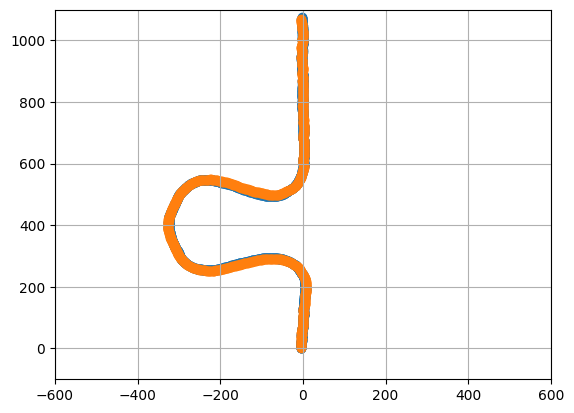

In [10]:
side_a = sides_a[3]
side_b = sides_b[3]

score, src, dst = get_score(
    piece_a_id,
    side_a["points"],
    piece_b_id,
    side_b["points"],
)

ax = plt.gca()
ax.set_xlim(-600, 600)
ax.set_ylim(-100, 1100)
ax.grid()
ax.scatter(dst[:, 0], dst[:, 1])
ax.scatter(src[:, 0], src[:, 1])

log.info(f"{score = }")

# Building comparison index

Compare all knobs with all holes to build an index with match scores. Scores are precomputed and stored to avoid recalculating them while solving the jigsaw.

Comparison index is a csv file with following columns: \
`piece_a_name`, `side_a_idx`, `side_a_type`, `piece_b_name`, `side_b_idx`, `side_b_type`, `score`

## Single threaded

In [11]:
def build_index(sides: dict[int, list[Side]], index_file_path: str) -> None:
    if os.path.exists(index_file_path):
        os.remove(index_file_path)
    if not os.path.exists(os.path.dirname(index_file_path)):
        os.makedirs(os.path.dirname(index_file_path))

    log.info("Processing...")

    n_pieces = len(sides)
    n_comparisons = 16 * (n_pieces - 1) * n_pieces // 2

    with open(index_file_path, "wt") as f, tqdm(total=n_comparisons) as pbar:
        writer = csv.writer(f)

        for piece_a_id, piece_b_id in combinations(range(1, n_pieces + 1), 2):
            sides_a = sides[piece_a_id]
            sides_b = sides[piece_b_id]

            for (side_a_idx, side_a), (side_b_idx, side_b) in product(
                enumerate(sides_a), enumerate(sides_b)
            ):
                if (side_a["type"], side_b["type"]) in (
                    ("knob", "hole"),
                    ("hole", "knob"),
                ):
                    # fmt: off
                    score = get_score(
                        piece_a_id, side_a["points"],
                        piece_b_id, side_b["points"],
                        reverse=True,
                    )[0]
                    writer.writerow(
                        [
                            piece_a_id, side_a_idx, side_a["type"],
                            piece_b_id, side_b_idx, side_b["type"],
                            score,
                        ]
                    )
                    # fmt: on

                pbar.update()

In [12]:
build_index(sides, os.path.join("data", "out_03", "sample_index_sp.csv"))

[2024-02-11 23:30:19][INFO] Processing...


100%|██████████| 12480/12480 [00:32<00:00, 381.22it/s]


## Distributed

In [13]:
@ray.remote
def compare_pieces(
    piece_a_sides: tuple[int, list[Side]],
    piece_b_sides: tuple[int, list[Side]],
) -> list[list[str | int]]:
    piece_a_id, sides_a = piece_a_sides
    piece_b_id, sides_b = piece_b_sides

    result = []
    for (side_a_idx, side_a), (side_b_idx, side_b) in product(
        enumerate(sides_a), enumerate(sides_b)
    ):
        if (side_a["type"], side_b["type"]) in (
            ("knob", "hole"),
            ("hole", "knob"),
        ):
            # fmt: off
            score = get_score(
                piece_a_id, side_a["points"],
                piece_b_id, side_b["points"],
                reverse=True,
            )[0]
            result.append(
                [
                    piece_a_id, side_a_idx, side_a["type"],
                    piece_b_id, side_b_idx, side_b["type"],
                    score,
                ]
            )
            # fmt: on
    return result

In [14]:
def build_index_ray(
    sides: dict[int, list[Side]],
    index_file_path: str,
    clear_sides: bool = False,
) -> None:
    log.info("Filling up object store memory...")
    ray_data_ids = [ray.put(item) for item in sides.items()]

    if clear_sides:
        sides.clear()

    log.info("Queueing tasks...")
    tasks = [
        compare_pieces.remote(ray_id_piece_a, ray_id_piece_b)
        for ray_id_piece_a, ray_id_piece_b in combinations(ray_data_ids, 2)
    ]

    def yield_ray(tasks: list[ray.ObjectRef]) -> Any:
        while tasks:
            done, tasks = ray.wait(tasks)
            yield ray.get(done[0])

    log.info("Yielding tasks...")
    with open(index_file_path, "wt") as f:
        writer = csv.writer(f)
        for result in tqdm(yield_ray(tasks), total=len(tasks)):
            writer.writerows(result)

In [15]:
ray.init()
build_index_ray(sides, os.path.join("data", "out_03", "sample_index_ray.csv"))
ray.shutdown()

2024-02-11 23:31:29,621	INFO worker.py:1724 -- Started a local Ray instance.


[2024-02-11 23:31:30][INFO] Filling up object store memory...
[2024-02-11 23:31:30][INFO] Queueing tasks...
[2024-02-11 23:31:30][INFO] Yielding tasks...


100%|██████████| 780/780 [00:04<00:00, 161.88it/s]


## Distributed with queue limit

In [16]:
def _combinations_count(iterable: collections.Sized, r: int) -> int:
    n = len(iterable)
    return math.factorial(n) // (math.factorial(r) * math.factorial(n - r))


def build_index_ray_limited(
    sides: dict[int, list[Side]],
    index_file_path: str,
    queue_limit: int,
    clear_sides: bool = False,
) -> None:
    log.info("Filling up object store memory...")
    ray_data_ids = [ray.put(item) for item in sides.items()]

    if clear_sides:
        sides.clear()

    log.info("Starting limited queue loop...")
    with (
        open(index_file_path, "wt") as f,
        tqdm(total=_combinations_count(ray_data_ids, 2)) as pbar,
    ):
        writer = csv.writer(f)

        tasks = []
        it = combinations(ray_data_ids, 2)
        while True:
            done, tasks = ray.wait(
                tasks,
                num_returns=min(queue_limit, len(tasks)),
                timeout=1,
            )

            to_fill = list(islice(it, queue_limit - len(tasks)))
            if not to_fill:
                break

            for a, b in to_fill:
                tasks.append(compare_pieces.remote(a, b))

            for record in done:
                writer.writerows(ray.get(record))
                pbar.update()

        for record in chain(done, tasks):
            writer.writerows(ray.get(record))
            pbar.update()

In [17]:
ray.init()
build_index_ray_limited(
    sides,
    os.path.join("data", "out_03", "sample_index_ray_limited.csv"),
    queue_limit=100,
)
ray.shutdown()

2024-02-11 23:32:27,473	INFO worker.py:1724 -- Started a local Ray instance.


[2024-02-11 23:32:28][INFO] Filling up object store memory...
[2024-02-11 23:32:28][INFO] Starting limited queue loop...


100%|██████████| 780/780 [00:05<00:00, 153.85it/s]


## Sanity check

In [18]:
record_regex = re.compile(r"(\d+,\d+,\w+),(\d+,\d+,\w+),(\d+.\d+)")

sp_path = os.path.join("data", "out_03", "sample_index_sp.csv")
ray_path = os.path.join("data", "out_03", "sample_index_ray.csv")
ray_lim_path = os.path.join("data", "out_03", "sample_index_ray_limited.csv")

with (
    open(sp_path, "rt") as index_sp,
    open(ray_path, "rt") as index_ray,
    open(ray_lim_path, "rt") as index_ray_lim,
):
    index_sp = set(
        frozenset(re.match(record_regex, record).groups())
        for record in index_sp.read().strip().split("\n")
    )
    index_ray = set(
        frozenset(re.match(record_regex, record).groups())
        for record in index_ray.read().strip().split("\n")
    )
    index_ray_lim = set(
        frozenset(re.match(record_regex, record).groups())
        for record in index_ray_lim.read().strip().split("\n")
    )

    assert index_sp == index_ray == index_ray_lim

# Complete dataset

In [19]:
sides: dict[int, list[Side]] = {}
with open(IN_PATH, "rb") as f:
    for piece_id, piece_sides in tqdm(pickle.load(f)):
        for piece_side in piece_sides:
            piece_side["points"] = np.array(piece_side["points"])
        sides[piece_id] = piece_sides

ray.init()
build_index_ray_limited(
    sides,
    os.path.join("data", "out_03", "index.csv"),
    queue_limit=10_000,
)
ray.shutdown()

100%|██████████| 2000/2000 [00:01<00:00, 1063.79it/s]
2024-02-11 23:33:51,491	INFO worker.py:1724 -- Started a local Ray instance.


[2024-02-11 23:33:52][INFO] Filling up object store memory...
[2024-02-11 23:33:52][INFO] Starting limited queue loop...


100%|██████████| 1999000/1999000 [5:05:19<00:00, 109.12it/s]  
